### Sumário

- Limites da DFT
- Introdução STFT 
- Parâmetros STFT 
- Parâmetros STFT - nperseg
- Parâmetros STFT - noverlap
- Conslusão

### Limites da DFT 

No tópico vamos discutir como usar a transformada de Fourier para determinar o conteúdo de frequência de um sinal no tempo e discutiremos os trade-offs envolvidos nesse processo.

Para começar vamos criar um sinal cujo conteúdo de frequência muda com o tempo.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Fs = 1000
tfinal = 8
fmin = 10
fmax = 20

In [3]:
def get_linear_chirp(fs, fmin, fmax, tfinal):
  freq_lin_coef = (fmax-fmin)/(2*tfinal)
  t = np.arange(0, tfinal, 1/fs)
  return np.sin(2*np.pi*(freq_lin_coef*t**2+fmin*t)), t

In [4]:
y, t = get_linear_chirp(Fs, fmin, fmax, tfinal)

No caso este temos um chirp linear cuja frequência começa em 10 Hz no instante 0 e varia linearmente até chegar a 20 Hz no instante 8s. Neste caso a frequência aumenta 1.25 Hz por segundo. 

A seguir temos o sinal e sua DFT:

In [5]:
y_fft = np.fft.fft(y)
y_fftp = np.abs(y_fft)/np.linalg.norm(np.abs(y_fft))
y_fft_hamming = np.fft.fft(y)
y_fftp_hamming = np.abs(y_fft_hamming)/np.linalg.norm(np.abs(y_fft_hamming))
freq = np.fft.fftfreq(len(y_fft))*Fs

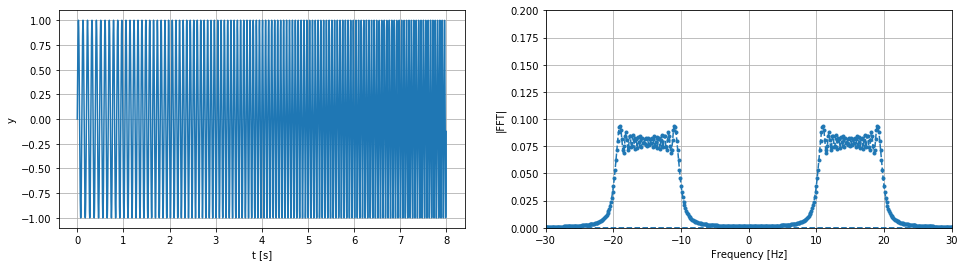

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16,4))
axs[0].plot(t, y)
axs[0].set_ylabel("y")
axs[0].set_xlabel("t [s]")
axs[0].grid()
axs[1].plot(freq, y_fftp, '.--')
axs[1].set_ylim([0, 0.2])
axs[1].set_xlim([-30, 30])
axs[1].set_ylabel("|FFT|")
axs[1].set_xlabel("Frequency [Hz]")
axs[1].grid()

Vemos pelo sinal e pela sua DFT que de fato a frequência está limitada entre 10 e 20Hz, contudo, a DFT não nos permite sabem como essa variação de frequência aconteu ao longo tempo, a frequência do sinal aumentou com tempo? Diminuiu? Ou todas essas frequências estavam presentes o tempo todo?.

### Introdução STFT 

Uma das maneiras de analisarmos como o conteúdo de frequência ao longo do tempo é usarmos chamada Short Time Fourier Transform (STFT). Podemos calcular a STFT com o numpy a função stft da biblioteca scypi.signal.

Vamos ver rapidamente como o gráfico gerado por uma STFT para ter uma idéia do que ela nos permite identificar.

In [7]:
from scipy.signal import stft

In [8]:
freq, time, y_stft = stft(y, fs=Fs, nperseg=512)

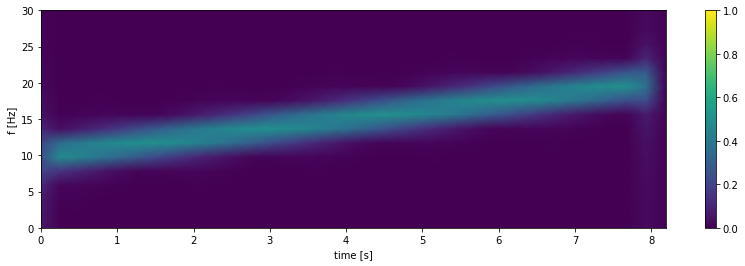

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(14, 4))
c = axs.pcolormesh(time, freq, np.abs(y_stft), vmin=0, vmax=1, shading='gouraud')
axs.set_ylim([0, 30])
axs.set_ylabel('f [Hz]')
axs.set_xlabel('time [s]')
fig.colorbar(c, ax=axs)

A SFTF nos mostra a energia do sinal para cada frequência no eixo y do gráfico e ao mesmo tempo nos mostra como essa distribuição de energia muda ao longo do tempo (eixo x). A intencidade do sinal para cada frequência é indicada pela escala de cor no gráfico.

Pela figura podemos ver claramente que a frequência do sinal começou com algo próximo a 10 Hz e foi aumentando linearmente com tempo até próximo de 20 Hz. Além disso, pela escala de cor também é possível ver que a energia do nosso sinal não variou com o tempo.

Agora que temos uma idéia do que esperar a da STFT vamos entender o que esta acontecendo. Para calcular o espectro do sinal ao longo do tempo o que a STFT está fazendo é simplesmente calcular várias DFT para diferentes segmentos do sinal, uma DFT para cada trecho do sinal é calculada e em seguida essas DFT são agrupadas gerando uma imagem 2D.

Podemos quantos DFT foram calculadas observando a dimensão da stft calculada:

In [10]:
y_stft.shape

(257, 33)

Neste caso tivermos 33 DFT com 257 pontos cada.

### Parâmetros STFT 

Vamos agora entender o efeito dos parâmetros envolvidos na SFTF e entender os trade-offs envolvidos. Para começar vamos listar os principais parâmetros com um breve resumo:

```
scipy.signal.stft(x, fs=1.0, window='hann', nperseg=256, noverlap=None, nfft=None, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=- 1)
```

- 1) x - O sinal que queremos analisar
- 2) fs - A frequência de amostragem usada na discretização do sinal
- 3) windown - A janela usada no cálculo da DFT (ver notebook Transformada_de_Fourier_e_Janelamento)
- 4) nperseg - Tamanho do segmento do sinal usada no calculo da DFT
- 5) noverlap - Sobreposição de amostras entre um segmento e o outro
- 6) nfft - Número de pontos usados no cálculo da DFT
- 7) boundary - Determina como o sinal é extendido nas bordas para centralizar os segmentos das bordas durante o calculo da DFT

Os parâmetros x, fs e windown são mais simples de entender pois também aparecem no calculo da DFT, o parâmetro nfft também já é conhecido pois determina o número de pontos na DFT e qual será a discretização do eixo da frequência.

De fato os parâmetros mais importantes para entender a STFT são nperset e noverlap.

### Parâmetros STFT  - nperseg

Vamos por enquanto fazer noverlap = 0 e boundary=None e ver o efeito de diferente noveralp.

In [11]:
nperseg1 = len(y)//2
nperseg2 = len(y)//4
nperseg3 = len(y)//25

In [12]:
freq1, time1, y_stft1 = stft(y, fs=Fs, nperseg=nperseg1, noverlap=0, boundary=None)
freq2, time2, y_stft2 = stft(y, fs=Fs, nperseg=nperseg2, noverlap=0, boundary=None)
freq3, time3, y_stft3 = stft(y, fs=Fs, nperseg=nperseg3, noverlap=0, boundary=None)

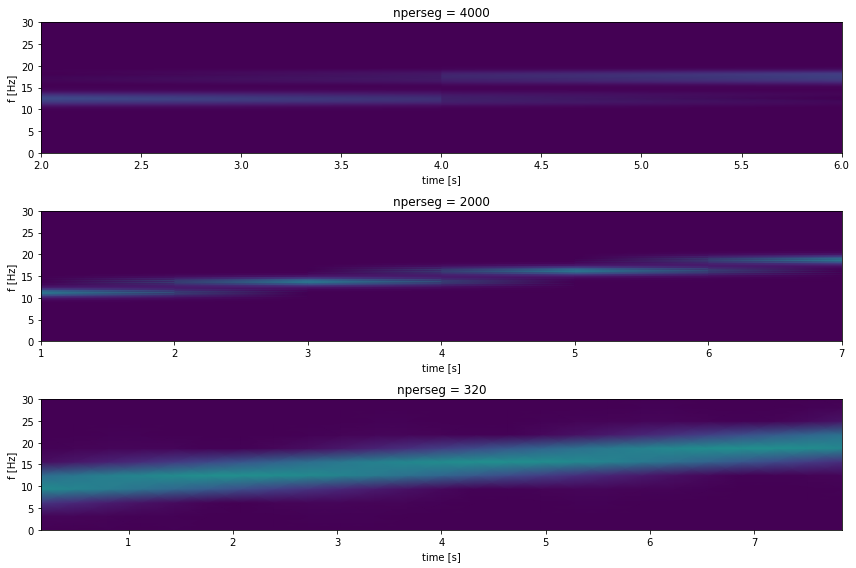

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(12, 8))
axs[0].pcolormesh(time1, freq1, np.abs(y_stft1), vmin=0, vmax=1, shading='gouraud')
axs[0].set_title("nperseg = 4000")
axs[0].set_ylim([0, 30])
axs[0].set_ylabel('f [Hz]')
axs[0].set_xlabel('time [s]')
axs[1].pcolormesh(time2, freq2, np.abs(y_stft2), vmin=0, vmax=1, shading='gouraud')
axs[1].set_title("nperseg = 2000")
axs[1].set_ylim([0, 30])
axs[1].set_ylabel('f [Hz]')
axs[1].set_xlabel('time [s]')
axs[2].pcolormesh(time3, freq3, np.abs(y_stft3), vmin=0, vmax=1, shading='gouraud')
axs[2].set_title("nperseg = 320")
axs[2].set_ylim([0, 30])
axs[2].set_ylabel('f [Hz]')
axs[2].set_xlabel('time [s]')

fig.tight_layout()

Olhando a figura acima vemos que nperseg determina o tamanho do segmento usando no calculado das DFTs, portanto caso queiramos dividir o sinal em 4 partes e ter uma resolução temporal de 2s escolhemos nperseg = len(y)//4. Isso nos permite saber o conteúdo de frequênca entre os instantes de tempo 0-2s, 2-4s, 4-6s e 6-8s.

Porém o nperseg também determina a resolução da DFT calculada, por isso quanto maior o valor de nperseg maio será o trecho do sinal usado e consequêntemente a resolução espectral para da uma dessas DFT será maior. Isso pode ser notado na figura ao vermos a espessura das linhas formadas, quanto menor o nperseg menos resolução temos e mais espessas são as linhas.

Neste exemplo o número de DFT calculadas foram 2, 4 e 25 respectivamente, ou seja, o parâmetro nperseg nos permite ajustar o trade-off entre resolução no tempo e resolução na frequência. Depedendo de nossa aplicação podemos estar interessados em saber quais frequências estão presentes do que exatemente quando ocorreram ou vice-versa.

### Parâmetros STFT - noverlap

Vamos agora entender o que o parâmetro noverlap faz, vamos manter o nperseg = 2000 e mudar o valor de overlap:

In [14]:
noverlap1 = int(1*len(y)/8)
noverlap2 = int(1.5*len(y)/8)

In [15]:
freq1, time1, y_stft1 = stft(y, fs=Fs, nperseg=2000, noverlap=noverlap1, boundary=None)
freq2, time2, y_stft2 = stft(y, fs=Fs, nperseg=2000, noverlap=noverlap2, boundary=None)

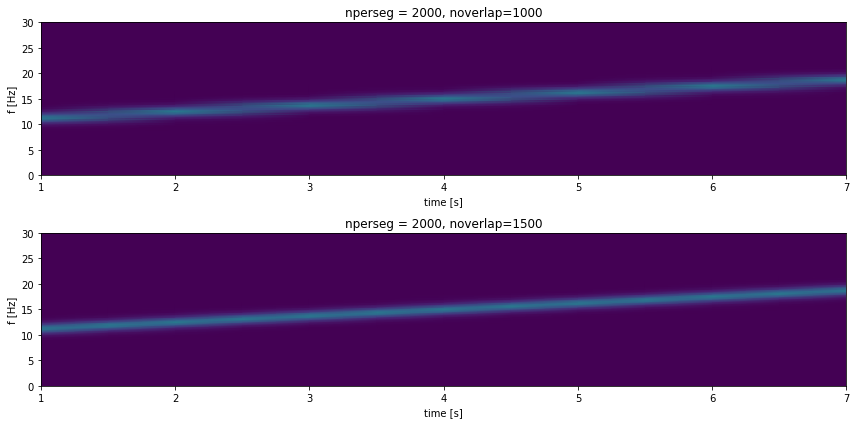

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
axs[0].pcolormesh(time1, freq1, np.abs(y_stft1), vmin=0, vmax=1, shading='gouraud')
axs[0].set_title("nperseg = 2000, noverlap=1000")
axs[0].set_ylim([0, 30])
axs[0].set_ylabel('f [Hz]')
axs[0].set_xlabel('time [s]')
axs[1].pcolormesh(time2, freq2, np.abs(y_stft2), vmin=0, vmax=1, shading='gouraud')
axs[1].set_title("nperseg = 2000, noverlap=1500")
axs[1].set_ylim([0, 30])
axs[1].set_ylabel('f [Hz]')
axs[1].set_xlabel('time [s]')
fig.tight_layout()

É possivel notar que apesar do mesmo valor de nperseg anterior as temos mais DFT calculadas ao longo do tempo, por exemplo, para a primeira figura temos 7 DFT calculadas e para a segunda temos 13, em ambos casos ao permitir um overlap temos mais DFT que antes. Se estamos mantendo o tamanho do seguemento usado para calcular a DFT de onde vem as novas DFT?


Lembramos que antes nosso sinal foi divididos nos intervalos 0-2, 2-4, 4-6 e 6-8, ou seja, não tínhamos nenhum overlap entre eleas, o parâmetro noverlap resolve exatamente isso permitindo nos analisar o que aconteceu entre esses intervalos.

No exemplo da primeira figura nosso sinal sinal ficou dividido em 7 partes, sendo elas: 0-2, 1-3, 2-4, 3-5, 4-6, 5-7, 6-8. 

Apesar de termos segmentos de 2 segundos temos um overlap de 1 segundo entre uma DFT e outra, isso nos ajuda a suavizar a visualização da variáçao da frequência embora ainda não resolva nosso problema de resolução temporal e frequência.

### Conclusão

Neste tópico discutimos:
- Comentamos sobre a limitação da DFT em identificar como as frequências do sinal mudam com o tempo
- Mostramso o que é a STFT e como ela ataca esta limitação
- Falamos de seus principais parâmetros e como eles afetam o trade-off resolução temporal e resolução espectral